## Needed Imports

In [1]:
# General imports
import pandas as pd 
import numpy as np
import warnings

# Imports for models
import matplotlib.pyplot as plt
import seaborn as sns

# Imports for data processing.
from sklearn import model_selection
from sklearn import preprocessing


# Improts for validations metrics
from sklearn import metrics as sm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Import for Linear regression
from sklearn import linear_model

# Import for Random Decision Tree
from sklearn.ensemble import RandomForestClassifier


## imports for Natual Bayers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [2]:
# Disabel warning filter spam, to activate set param to 'Always'
warnings.filterwarnings('ignore') 

## Data preperation

Opdagede desværrer at daten ikke var særlig godt sammensat for min stil. Alle værdier i vores kolonner var omgivet af ", derfor løber vi den igennem en cleaner og opretter en "Reparied" fil, som vi vil arbejde på gennem resten af projektet.

Forfatteren af dataen har også haft flere linjer der har haft 1-2 ekstra kolonner ekstra end hvad der er lavet headers på. Da forfatteren heller ikke har beskrevet disse i deres dokumentation, valgte jeg at eliminere dem fra min pandas DataFrame. Dette gøres med parameteret <b>error_bad_lines=False</b>

Det resulterede desværrer i et tab på omkring 500 linjer data. Hvilket har gør et allerede ret sketchy datasæt til et væsentligt mere upræcist datasæt

In [4]:
lines = []
with open('data/video_games.csv', 'r') as input:
    lines = input.readlines()

conversion = '"'
newtext = ''
outputLines = []
for line in lines:
    temp = line[:]
    for c in conversion:
        temp = temp.replace(c, newtext)
    outputLines.append(temp)

with open('data/video_games_reparied.csv', 'w') as output:
    for line in outputLines:
        output.write(line)

In [5]:
df = pd.read_csv('data/video_games_reparied.csv', index_col=False, encoding='iso-8859-1', nrows=1000,
                        warn_bad_lines=False, error_bad_lines=False)



Tilføjer en ekstra kolonne hvor jeg gruppere spillenes anmeldelses score i fire grupper. Disse 4 grupper er mine mål for mit Random decission tree der skal benyttes til at forudsige hvilken karakter gruppe vores spil vil lande inden for med et sæt givende parameter. 

In [6]:
def group_review_score():
    df['Metrics.Review Group'] = ''
    df.loc[df['Metrics.Review Score'] <= 25, 'Metrics.Review Group'] = 1
    df.loc[(df['Metrics.Review Score'] >= 26) & (df['Metrics.Review Score'] <=50), 'Metrics.Review Group'] = 2
    df.loc[(df['Metrics.Review Score'] >= 51) & (df['Metrics.Review Score'] <=75), 'Metrics.Review Group'] = 3
    df.loc[(df['Metrics.Review Score'] >= 76) & (df['Metrics.Review Score'] <=100), 'Metrics.Review Group'] = 4



Jeg havde 167 null værdier på 'Metadata.Publisher', og valgte at udfylde dem med 'Unknown' værdien
'Metrics.Sales' er omregenet fra 'In million dollars' til 'In thousands dollars' - dette er af rent afstetiske årsager, da jeg personligt ikke kan lide 0.xx værdier. Efter testing burde der ikke være forskel på resultaterne for forudsiglers. 

In [7]:
# We had 167 nan values on the puplisher column, we will replace those with "Unknown" publishers. 
df['Metadata.Publishers'].fillna('Unkown', inplace = True)
# For prettier numbers, we'll turn the Sales from "in millions" to "in thousands".
df['Metrics.Sales']= df['Metrics.Sales']*1000

# Group the review scores into 4 classes for later confusion matrix
group_review_score()


In [8]:
df.head()

,Title,Features.Handheld,Features.Max Players,Features.Multiplatform,Features.Online,Metadata.Genres,Metadata.Licensed,Metadata.Publishers,Metadata.Sequel,Metrics.Review Score,...,Length.Main + Extras.Leisure,Length.Main + Extras.Median,Length.Main + Extras.Polled,Length.Main + Extras.Rushed,Length.Main Story.Average,Length.Main Story.Leisure,Length.Main Story.Median,Length.Main Story.Polled,Length.Main Story.Rushed,Metrics.Review Group
0,Super Mario 64 DS,True,1,True,True,Action,True,Nintendo,True,85,...,29.966667,25.00,16,18.333333,14.333333,18.316667,14.5,21,9.700000,4
1,Lumines: Puzzle Fusion,True,1,True,True,Strategy,True,Ubisoft,True,89,...,9.866667,9.75,2,9.616667,10.333333,11.083333,10.0,3,9.583333,4
2,Hot Shots Golf: Open Tee,True,1,True,True,Sports,True,Sony,True,81,...,0.000000,0.00,0,0.000000,0.000000,0.000000,0.0,0,0.000000,4
3,Spider-Man 2,True,1,True,True,Action,True,Activision,True,61,...,17.316667,12.50,12,10.483333,8.350000,11.083333,8.0,23,5.333333,3
4,The Urbz: Sims in the City,True,1,True,True,Simulation,True,EA,True,67,...,25.200000,20.00,3,16.450000,15.500000,15.750000,15.5,2,15.250000,3


## DataInfo (Optional to run)

This section is optional to run, it was used for my own understanding of the data, and finding the featuers and labels that was needed. Also checked the data for null amounts etc. 

In [9]:
list(df) # list of column headers name

['Title',
 'Features.Handheld',
 'Features.Max Players',
 'Features.Multiplatform',
 'Features.Online',
 'Metadata.Genres',
 'Metadata.Licensed',
 'Metadata.Publishers',
 'Metadata.Sequel',
 'Metrics.Review Score',
 'Metrics.Sales',
 'Metrics.Used Price',
 'Release.Console',
 'Release.Rating',
 'Release.Re-release',
 'Release.Year',
 'Length.All PlayStyles.Average',
 'Length.All PlayStyles.Leisure',
 'Length.All PlayStyles.Median',
 'Length.All PlayStyles.Polled',
 'Length.All PlayStyles.Rushed',
 'Length.Completionists.Average',
 'Length.Completionists.Leisure',
 'Length.Completionists.Median',
 'Length.Completionists.Polled',
 'Length.Completionists.Rushed',
 'Length.Main + Extras.Average',
 'Length.Main + Extras.Leisure',
 'Length.Main + Extras.Median',
 'Length.Main + Extras.Polled',
 'Length.Main + Extras.Rushed',
 'Length.Main Story.Average',
 'Length.Main Story.Leisure',
 'Length.Main Story.Median',
 'Length.Main Story.Polled',
 'Length.Main Story.Rushed',
 'Metrics.Review Group

In [10]:
df.info() # Shows a more detailed view of the dataframe, including data types and amount of nulls.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 845 entries, 0 to 844
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Title                          845 non-null    object 
 1   Features.Handheld              845 non-null    bool   
 2   Features.Max Players           845 non-null    int64  
 3   Features.Multiplatform         845 non-null    bool   
 4   Features.Online                845 non-null    bool   
 5   Metadata.Genres                845 non-null    object 
 6   Metadata.Licensed              845 non-null    bool   
 7   Metadata.Publishers            845 non-null    object 
 8   Metadata.Sequel                845 non-null    bool   
 9   Metrics.Review Score           845 non-null    int64  
 10  Metrics.Sales                  845 non-null    float64
 11  Metrics.Used Price             845 non-null    float64
 12  Release.Console                845 non-null    obj

Action                465
Sports                166
Strategy               59
Role-Playing (RPG)     52
Racing / Driving       51
Simulation             30
Adventure              20
Educational             2
Name: Metadata.Genres, dtype: int64


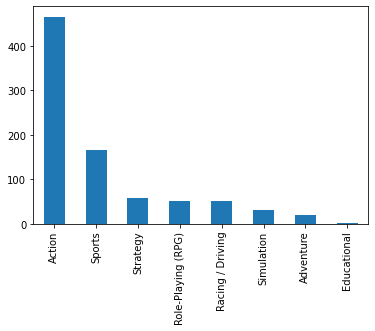

In [11]:
print(df['Metadata.Genres'].value_counts()) # Shows a list of Genres, including the amount entries with the genre value
df['Metadata.Genres'].value_counts().plot(kind='bar') # same but in bar from

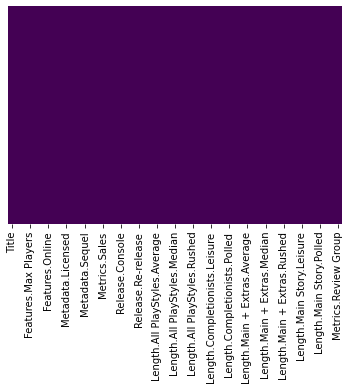

In [12]:
# visualization on a heatmap for null values.
sns.heatmap(df.isnull(), yticklabels= False, cbar=False, cmap= 'viridis')

## Data Analysis

### Corrolation Matrix

For at udse mig de rette featuers(X) og label(y) værdier til mine modeller, har jeg benyttet en <b>corrolation matrix</b>. 

En Corrolation matrix krydsreffere alle vores columns og deres sammenhængen og effekt på hinaden. sammenhængen vurderes på en skala fra -1.0 til +1.0. Jo tættere på +1.0 jo størrer er sammenhængen. 

eksemple:
corrolationen mellem vores Metrics.Sales og Metrics.Review Score, har en vurdering på 0.32. Det betyder at disse to columns har en positiv effekt på en eventuelle model. Hvor værider i minus skalaen har en negatvi effekt på eventuelle modeller.

## ____

#### Min model

Min data score ualmindeligt dårligt på corrolation matrixen.
(Ind kommenter øverstelinje for correlation matrix med alle labels)

De enste positive punkter er 'Metrics.Review Score','Metrics.Sales', 'Release.Year', 'Features.Max Players'. Men de er alle under 0.50, og derfor ikke særlig effektive. Men da det er de bedste score hvilket vil afspejelse sig i vores validering af vores modeller. 

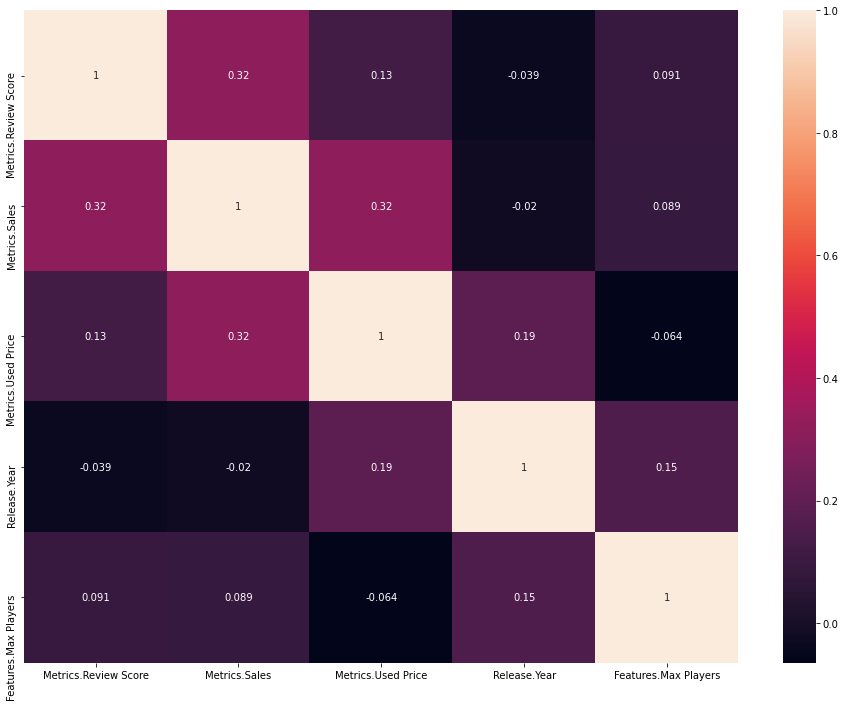

In [13]:
# df_corr = df.drop(['Features.Handheld', 'Features.Max Players', 'Features.Multiplatform', 'Features.Online', 'Metadata.Licensed',  'Metadata.Sequel', 'Release.Re-release'], 1)
df_corr = df[['Metrics.Review Score','Metrics.Sales', 'Metrics.Used Price', 'Release.Year', 'Features.Max Players',]]
corr_matrix = df_corr.corr()
plt.subplots(figsize = (16, 12))
sns.heatmap(corr_matrix, annot=True)
plt.savefig('Corr_matrix.png')

## Multiple Linear regression

### Case
Jeg vil som spil firma gerne finde ud af hvordan jeg producere et spiler der skal genere det højst mulige salg. Ved hjælp af vores data fitter vi en linear reggreasion der kan fortælle os hvor meget vores produkut kommer til at sælge for hvis vi rammer de rigige features. vores features er.

- Metrics.Review Score
- Release.Year
- Features.Max Players
- Metadata.Genres

Altså, hvad review score skal jeg gå efter. Hvilket år udgiver jeg mit spil, hvor mange spillere skal der være og hvilke genre af spil skal jeg udvikle. Jeg kan som producent tweak de små parameter og så en forudsigelse på hvad mit spil vil komme til at sælge
   

Da classifications kun kan operere med numeriske værdier, vælger jeg at encode alle mine lables der ikke allerede er numerisk værdi. Encoding konvertere vores string data ind til numerisk værdi.

ex på min encoded Metics.Genres

<table>
    <thead>
        <tr>
            <th>Original label</th>
            <th>Encoded label</th>
        </tr>
    </thead>
    <tbody>
        <tr>
         <td>Action</td>
         <td>0</td>
        </tr>
        <tr>
            <td>Sports</td>
        <td>1</td>
            </tr>
<tr>
<td><b>...</b></td>
 <td><b>...</b></td>
 </tr>
   <tr>
<td>Adventure</td>
<td>5</td>
 </tr>
<tr>
<td>Educational</td>
 <td>7</td>
 </tr> 
</tbody>
</table>



In [14]:
def makeListForLabel(label_name):
    myList = df[label_name]
    tempArray = []
    for word in myList:
        if word not in tempArray:
            tempArray.append(word)
    return tempArray   

In [15]:

df_encoded = pd.DataFrame()

labels = {
    'Metadata.Genres': makeListForLabel('Metadata.Genres'),
    'Metadata.Publishers': makeListForLabel('Metadata.Publishers'),
    'Features.Handheld': makeListForLabel('Features.Handheld'),
    'Features.Multiplatform': makeListForLabel('Features.Multiplatform'),
    'Features.Online': makeListForLabel('Features.Online'),
    'Metadata.Licensed': makeListForLabel('Metadata.Licensed'),
    'Metadata.Sequel': makeListForLabel('Metadata.Sequel'),
    'Release.Console': makeListForLabel('Release.Console'),
    'Release.Rating': makeListForLabel('Release.Rating'),
    
}
label_encoders = {}
for column in df:
    if column in labels:
        label_encoders[column] = preprocessing.LabelEncoder()
        label_encoders[column].fit(labels[column])
        df_encoded[column] = label_encoders[column].transform(df[column])
    else:
        df_encoded[column] = df[column]      

Release.year har en meget dårlig correlation med de andre features. Men efter at have teste med og uden, og fundet en meget lille forskel. valgte jeg at lade den indgå fordi jeg ser det som en af de værdier en producer gerne ville have målsat efter i det virkelige liv
  

In [16]:
Multi_features = np.array(df_encoded[[
    'Metrics.Review Score', 
    'Release.Year', 
    'Features.Max Players',
    'Metadata.Genres'  
     ]    
])
Multi_label = np.array(df_encoded['Metrics.Sales'])
Multi_regressor = linear_model.LinearRegression()

# ---------- RESULT WITH 4 Features --------------,

# Mean squared error: 431266.32\n",
# R-squared (training)  0.129\n",
# R-squared (testing)  0.008\n",
# Explained variance score  0.05\n",
# R2 score: 0.01"

In [17]:
# ---------- RESULT WITH 3 Features --------------

# Multi_features = np.array(df_encoded[[
#    'Metrics.Review Score'
#    'Features.Max Players'
#    'Metadata.Genres'


# Multi_label = np.array(df_encoded['Metrics.Sales'])
# Multi_regressor = linear_model.LinearRegression()

# Mean squared error: 428889.71
# R-squared (training)  0.128
# R-squared (testing)  0.013
# Explained variance score  0.05\n
# R2 score: 0.01

Ved at ændre test_size og random_state har det lykkedes mig at lave lille bitte ændringer på scoren. Men ikke noget der har haft væsentlig betydning.
  

In [18]:
Multi_features_train, Multi_features_test, Multi_label_train, Multi_label_test = model_selection.train_test_split(Multi_features,Multi_label, test_size = 0.25, random_state = 5)
Multi_regressor.fit(Multi_features_train,Multi_label_train)

LinearRegression()

### Prediction of Sales in Thousand $ In Linear Regression

In [19]:
Multi_label_prediction = Multi_regressor.predict(Multi_features_test)
Multi_label_prediction

array([ 241.19455729,  716.31816102,  559.7826688 , -240.20374836,
        430.85530271,  275.36164049, 1069.08337745,  744.67343239,
       1157.27468156,  335.35748841,  484.13237839,  695.42921503,
        -93.51211049,  926.58318939,  686.92105965,  209.26092755,
       1279.34840582,  559.94289188,  385.64353577,  619.61870154,
       1098.48047882,  749.45343594,  777.06156208,   94.20905044,
        152.25610795,  739.15630533, 1000.73918934,  717.51980621,
        443.98323856,  397.73045741,  657.52395828, 1561.07309058,
        334.15584322,  275.36164049,  591.12937638,  245.96453912,
        854.79551249,  456.52466015,  621.56789985,  610.22893924,
        598.72975555, 1157.27468156, 1053.72158025,  474.58239301,
        736.32550009,  859.43103263,  696.17636026,  392.95004596,
        197.92115115, -458.81874851,  412.79716195,  887.93078741,
        342.6639986 , 1132.36289898,  265.81165511,  715.27633102,
         33.62587247,  240.44741206,  980.89207334,  308.04363

Hvis jeg laver et spil, jeg forventer får en review score på 85, som jeg vil udgive i 2020. Det er et single player spil af genren adventure. Så vil jeg kunne forudsige min Metrics.Sales med min linear reggression.

In [20]:
# newData [Metrics.Review Score, Release.year, Features.Max Players, Metadata.Genres]
newData = np.array([85, 2020, 1, 1]).reshape(1,-1)
print(round(Multi_regressor.predict(newData)[0], 2),'$')

527.82 $


## Validation of Multiple Variable regression

mean squared error:
> er en sammenligning mellem de observeret y værdier og de forudsagte y værdier, i anden potence for at udligne negative tal. Jo højere scoren er, jo mere upræcisis er modellen.

variance socre:
>forklare hvor langt værdierne ligger fra den gennemsnitlige værdi i forhold til R2

R2 score:
>er et score fra 0 til 100% og kan beskrives som variancen mellem den afhængige og ikke-afhængige variable(r) ved 100% ville der være en prævises corrolation mellem mine features. Som det kunne ses i corrolation matrixen, var der meget lav sammenhængen, og det afspejler sig også i scoren som er meget lav
   

In [21]:
# The mean squared error
print("Mean squared error: %.2f" % sm.mean_squared_error(Multi_label_test, Multi_label_prediction))

# Explained variance score: 1 is perfect prediction
print('R-squared (training) ', round(Multi_regressor.score(Multi_features_train, Multi_label_train), 3))
print('R-squared (testing) ', round(Multi_regressor.score(Multi_features_test, Multi_label_test), 3))
print('Explained variance score ', round(sm.explained_variance_score(Multi_label_test, Multi_label_prediction), 2))
print('R2 score: %.2f' % sm.r2_score(Multi_label_test, Multi_label_prediction))

Mean squared error: 431266.32
R-squared (training)  0.129
R-squared (testing)  0.008
Explained variance score  0.05
R2 score: 0.01


## Random Forrest Classifier

### Case

Jeg ønsker nu at finde ud af hvilke features jeg skal ramme for at ramme en Metrice.Review Socre på 75+ for at ramme inden for vores salgs mål i vores linear model.

Til dette har jeg benyttet et Random Forrest Classifier

RAndom Forrest classifier er en stor samling af Decision trees, der tilfældigt bliver konstrueret.
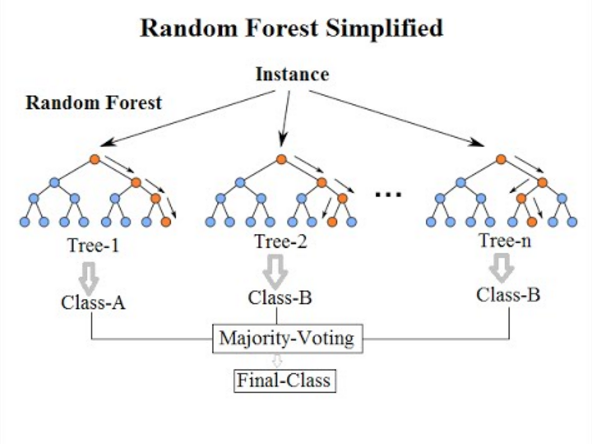
Random Decision Tree fungere ved at hver node i trææet repræsentere en feature og hvert udspring af træetes node repræsentere en mulig value. Opgaven for et Decision tree er at forudsige et label baseret på fixed værider. Resultatet af de forskellige trærer bliver samelt, og valuen med flest "Stemmer" bliver valgt som udfaldet



In [22]:
DT_features = np.array(df_encoded[[
    'Release.Year', 
    'Features.Max Players',
    'Metadata.Genres',
    ]    
])
DT_label = np.array(df_encoded['Metrics.Review Group'])
DT_label=DT_label.astype('int')

In [23]:
class0 = np.array(DT_features[(DT_label== 0)])
class1 = np.array(DT_features[(DT_label == 1)])
class2 = np.array(DT_features[(DT_label == 2)])
class3 = np.array(DT_features[(DT_label == 3)])
class1

array([[2007,    4,    0],
       [2007,    1,    7],
       [2007,    1,    0]], dtype=int64)

In [24]:
DT_features_train, DT_features_test, DT_label_train, DT_label_test = model_selection.train_test_split(DT_features, DT_label, test_size=0.1, random_state=5)

Random Forest Classifier har 6 ofte brugte parameter
- n_estimators: antalelet af decision trees i vores forrest
- criterion: Bruger vi Gini eller Entropy til at beregne
- max_features: Det maximale antal features der bliver overvejet i hvert Decision tree
- max_dept: Dybden af vores Decision trees.

Desværrer er min data så upræcsis, at ændringer ikke har givet et særligt stort udsving i vores validation scores.

In [25]:
# classifier = RandomForestClassifier(n_estimators = 200, criterion='entropy', max_depth = 6) # Score 0.62
classifier = RandomForestClassifier(n_estimators = 500, criterion='entropy', max_depth = 8) # Score 0.62
classifier.fit(DT_features_train, DT_label_train)

RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=500)

## Validate our Decision tree model

In [26]:
review_score_prediction = classifier.predict(DT_features_test)
review_score_prediction

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3])

Jeg ønsker at udvikle et spil, der er udgivet i 2020, af genren Adventure, og ser et singleplayer spil. prediction vil ender i en af fire klasser.

 1 = score below 25
 
 2 = score between 26 and 50
 
 3 = score between 50 and 75
 
 4 = score between 76 and 100

In [27]:
# DT_NewData = np.array([2000, 1, 3]) # is predicted to be in group 4.
DT_NewData = np.array([2020, 1, 1]) # is predicted to be in group 3.
DT_NewData_predicted = classifier.predict([DT_NewData])
print('Your game will likely bescored in group:',DT_NewData_predicted[0],)

# 1 = score below 25
# 2 = score between 26 and 50
# 3 = score between 50 and 75
# 4 = score between 76 and 100

Your game will likely bescored in group: 3


In [28]:
class_names = ['score 0-25', 'score 26-50', 'score 51-75','score 76-100']
print(classification_report(DT_label_test, classifier.predict(DT_features_test), target_names=class_names))

              precision    recall  f1-score   support

  score 0-25       0.00      0.00      0.00         1
 score 26-50       0.00      0.00      0.00         5
 score 51-75       0.61      0.98      0.75        49
score 76-100       0.83      0.17      0.28        30

    accuracy                           0.62        85
   macro avg       0.36      0.29      0.26        85
weighted avg       0.64      0.62      0.53        85



Med en confusion matrix, kan vi hurtigt kortlægge vores TureNegative, TruePositive, False Negative, og False Positive.

En Confusion matrix skal læses som set på billede, Diagonale cæller er de koreket forudsagte punkter.

(Billede Source, Undervisnings materiale udleveret af Dora(Vores lærer).)

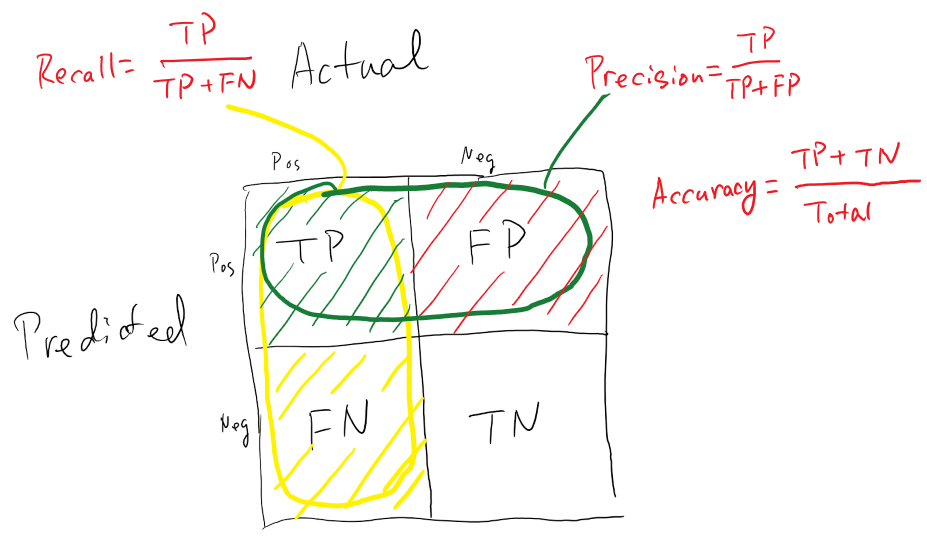

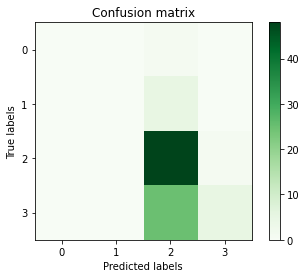

In [29]:
confusion_mat = confusion_matrix(DT_label_test,classifier.predict(DT_features_test))
confusion = pd.crosstab(DT_label_test,classifier.predict(DT_features_test))


# Visualize confusion matrix
plt.imshow(confusion_mat, interpolation='nearest', cmap = 'Greens')
plt.title('Confusion matrix')
plt.colorbar()
ticks = np.arange(len(confusion))
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.grid(False)

plt.ylabel('True labels')
plt.xlabel('Predicted labels')

plt.show()

In [30]:
confusion # Confusion matrix in numbers

col_0,3,4
row_0,,
1,1,0
2,5,0
3,48,1
4,25,5




Som vi kan se har vi kun korrekt forudsagt 48 i grupp 3, 5 spil i gruppe 4. Det er en klar endikation på at modellen har en rigitg dårlig præcision. Men stemmer over ens med vores accurracy_score ~60%  

## Natural Bayers og Natural Language Processing

### CASE

Jeg har fundet ud af hvad socre jeg skal skyde efter for at have en bestem omsætning ved hjælp af Linear reggresion og Random Forest Classifier. Det har også fortalt mig hvilken genre jeg skal gå efter, udgivelse år, antal spiller der skal til i spillet.

Så mit sidste skridt er at finde ud af hvad mit spil skal hedde. Ved hjælp af Natural Bayers og Natural Language Processing, kan jeg med min data udse mig hvilket ord der bedst falder ind under en spil title inden for en genre.


Hvis pam og ham(X aksen), er vores labels, så i stedet for spam eller ham, ville der står Action, sports, etc.
rowsne(Y aksen) vil så være vores ord udvalg, og fælterne ville være hvor mange gange orderene indgår i genren. Vi kan således udregne sandsynligheden for at et ord tilhørrer et hvis genre

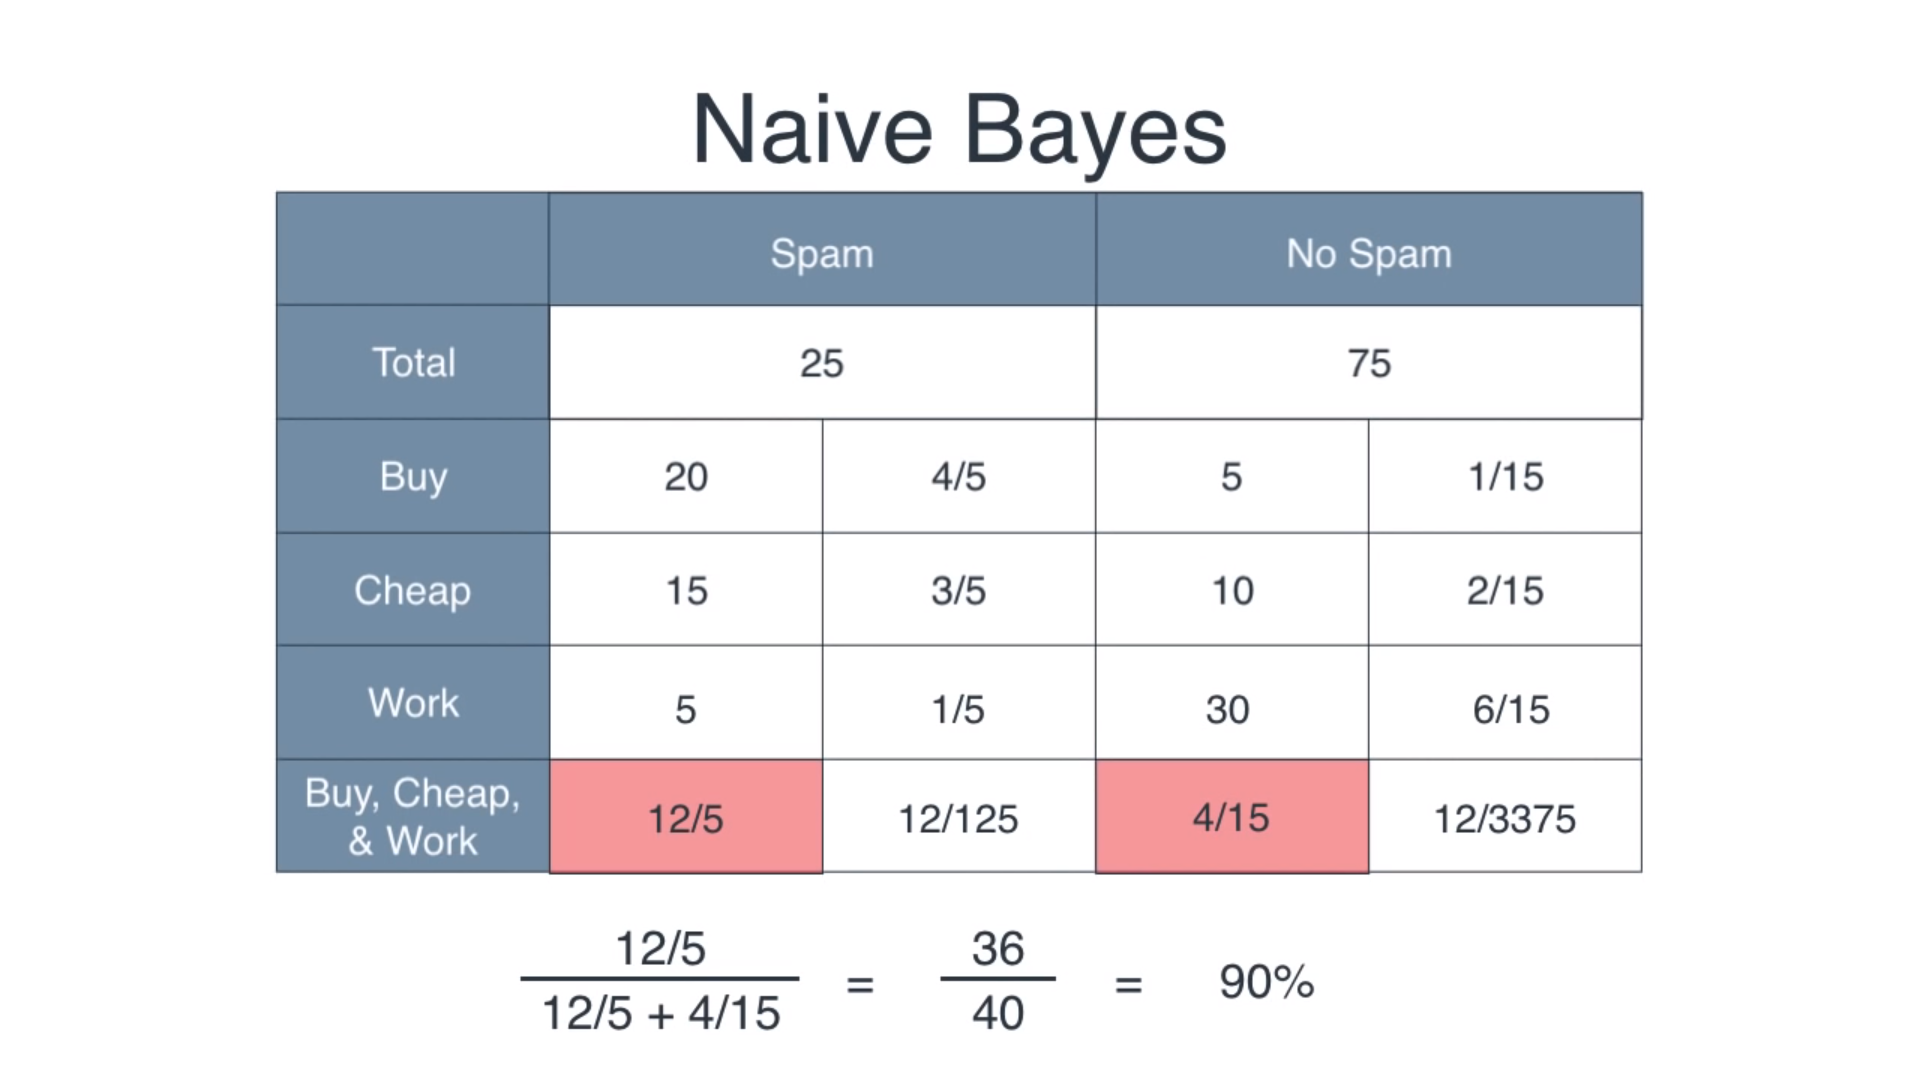


In [31]:
NB_label = np.array(df['Metadata.Genres'])
NB_features = np.array(df['Title'])
target_names = ['Action', 'Sports','Strategy','Role-Playing (RPG)','Racing / Driving', 'Simulation','Adventure', 'Educational']

In [33]:
NB_features_train, NB_features_test,NB_label_train,NB_label_test = model_selection.train_test_split(NB_features, NB_label, test_size=0.25, random_state = 5)

In [34]:
# create an instance of the vectorizer 
tfidf = TfidfVectorizer(encoding='utf-8',lowercase=True, stop_words='english', max_df=0.5, sublinear_tf=True, use_idf=True)

# implement it for processing the train data
word_vect = tfidf.fit_transform(NB_features_train)

# see the output of vectorization per document in the format (document, word index) score, unsorted
print(word_vect[0:5, ])

  (0, 337)	0.5399371276999435
  (0, 577)	0.5399371276999435
  (0, 349)	0.4565828491425569
  (0, 744)	0.4565828491425569
  (1, 1)	0.5098014175581421
  (1, 301)	0.6166573622090623
  (1, 508)	0.5998634947128139
  (2, 263)	0.46257841079085493
  (2, 631)	0.4845172337090084
  (2, 380)	0.392701480550436
  (2, 406)	0.4455613376868962
  (2, 202)	0.4455613376868962
  (3, 3)	0.5809120072010635
  (3, 513)	0.5701600475123305
  (3, 448)	0.5809120072010635
  (4, 242)	1.0


In [35]:
# get the vector for the first document
first_vector = word_vect[50]
 
# place tf-idf values in a pandas data frame to see it in more readable format
df_NB = pd.DataFrame(first_vector.T.todense(), index=tfidf.get_feature_names(), columns=["tfidf"])
df_NB.sort_values(by=["tfidf"],ascending=False)

,tfidf
prostreet,0.670441
need,0.531975
speed,0.517215
06,0.000000
potter,0.000000
...,...
fantastic,0.000000
fantasy,0.000000
far,0.000000
fast,0.000000


In [36]:
# we choose multinomial Naive Bayes 
NB_classifier = MultinomialNB()

In [37]:
# connect the vectorizer to the multinomial classifier
model = make_pipeline(tfidf, NB_classifier)

In [38]:
# train a model
model.fit(NB_features_train, NB_label_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.5, stop_words='english',
                                 sublinear_tf=True)),
                ('multinomialnb', MultinomialNB())])

In [39]:
# use the trained model to predict categories for the test data
genre_predicted = model.predict(NB_features_test)
genre_predicted

array(['Sports', 'Action', 'Action', 'Action', 'Action', 'Action',
       'Action', 'Action', 'Action', 'Action', 'Sports', 'Action',
       'Action', 'Sports', 'Action', 'Action', 'Sports', 'Sports',
       'Action', 'Action', 'Action', 'Sports', 'Sports', 'Sports',
       'Sports', 'Sports', 'Action', 'Action', 'Action', 'Action',
       'Action', 'Action', 'Action', 'Action', 'Action', 'Action',
       'Action', 'Action', 'Sports', 'Sports', 'Action', 'Action',
       'Sports', 'Sports', 'Sports', 'Action', 'Action', 'Action',
       'Action', 'Action', 'Action', 'Sports', 'Action', 'Sports',
       'Action', 'Action', 'Sports', 'Sports', 'Action', 'Action',
       'Action', 'Action', 'Action', 'Action', 'Sports', 'Action',
       'Action', 'Sports', 'Action', 'Sports', 'Action', 'Action',
       'Sports', 'Sports', 'Action', 'Action', 'Action', 'Action',
       'Racing / Driving', 'Action', 'Action', 'Action', 'Action',
       'Action', 'Action', 'Role-Playing (RPG)', 'Action', 'Sp

In [40]:
# measure the accuracy of the training
model.score(NB_features_test,NB_label_test)

0.7971698113207547

In [41]:
# calculate the accuracy of the model with the test set
accuracy = accuracy_score(NB_label_test, genre_predicted)
accuracy

0.7971698113207547

In [42]:
# calculate confusion matrix to further evaluate the the accuracy of the prediction
cmat = confusion_matrix(NB_label_test, genre_predicted)
cmat

array([[120,   0,   0,   0,   0,   0,   0],
       [  3,   0,   0,   0,   0,   0,   0],
       [  2,   0,   2,   0,   0,   0,   0],
       [ 12,   0,   0,   1,   0,   0,   0],
       [ 10,   0,   0,   0,   0,   0,   0],
       [  2,   0,   0,   0,   0,  46,   0],
       [ 14,   0,   0,   0,   0,   0,   0]], dtype=int64)

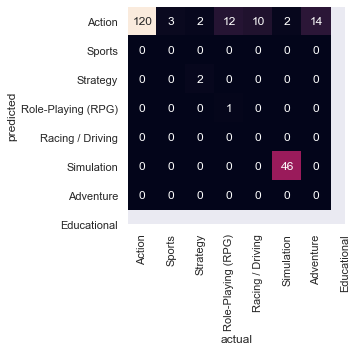

In [43]:
# visualize the confusion matrix by use of seaborn library
sns.set()
sns.heatmap(cmat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('actual')
plt.ylabel('predicted');
plt.show()

In [44]:
# print accuracy evaluation report
report = classification_report(NB_label_test, genre_predicted)
print(report)

                    precision    recall  f1-score   support

            Action       0.74      1.00      0.85       120
         Adventure       0.00      0.00      0.00         3
  Racing / Driving       1.00      0.50      0.67         4
Role-Playing (RPG)       1.00      0.08      0.14        13
        Simulation       0.00      0.00      0.00        10
            Sports       1.00      0.96      0.98        48
          Strategy       0.00      0.00      0.00        14

          accuracy                           0.80       212
         macro avg       0.53      0.36      0.38       212
      weighted avg       0.72      0.80      0.72       212



In [45]:
def my_prediction(string, train = NB_features_train, model=model):
    genre_predicted = model.predict([string])
    return genre_predicted[0]

In [46]:
print(my_prediction('Fun'))
print(my_prediction('Speed'))
print(my_prediction('FootBall'))
print(my_prediction('need'))

print('####################')
print(df['Metadata.Genres'].value_counts())

Action
Racing / Driving
Sports
Racing / Driving
####################
Action                465
Sports                166
Strategy               59
Role-Playing (RPG)     52
Racing / Driving       51
Simulation             30
Adventure              20
Educational             2
Name: Metadata.Genres, dtype: int64
